In [ ]:
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
import pandas as pd 
import numpy as np
import os as os 
from sklearn.model_selection import train_test_split
from pandas import DataFrame
#import category_encoders as ce
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Defining a function to evaluate models:

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
def evaluate_model(X, y, model):
  X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.3,random_state=42,shuffle=True)
  # predict the test points and plot them onto the chart
  model.fit(X_train, y_train)
  y_hat = model.predict(X_test)
  return mean_absolute_error(y_test,y_hat) ,mean_squared_error(y_test, y_hat), r2_score(y_test, y_hat)

In [ ]:
df_train_valid = pd.read_csv("./drive/MyDrive/Competition/dev.tsv", sep="\t")
df_test = pd.read_csv("./drive/MyDrive/Competition/eval.tsv", sep="\t")

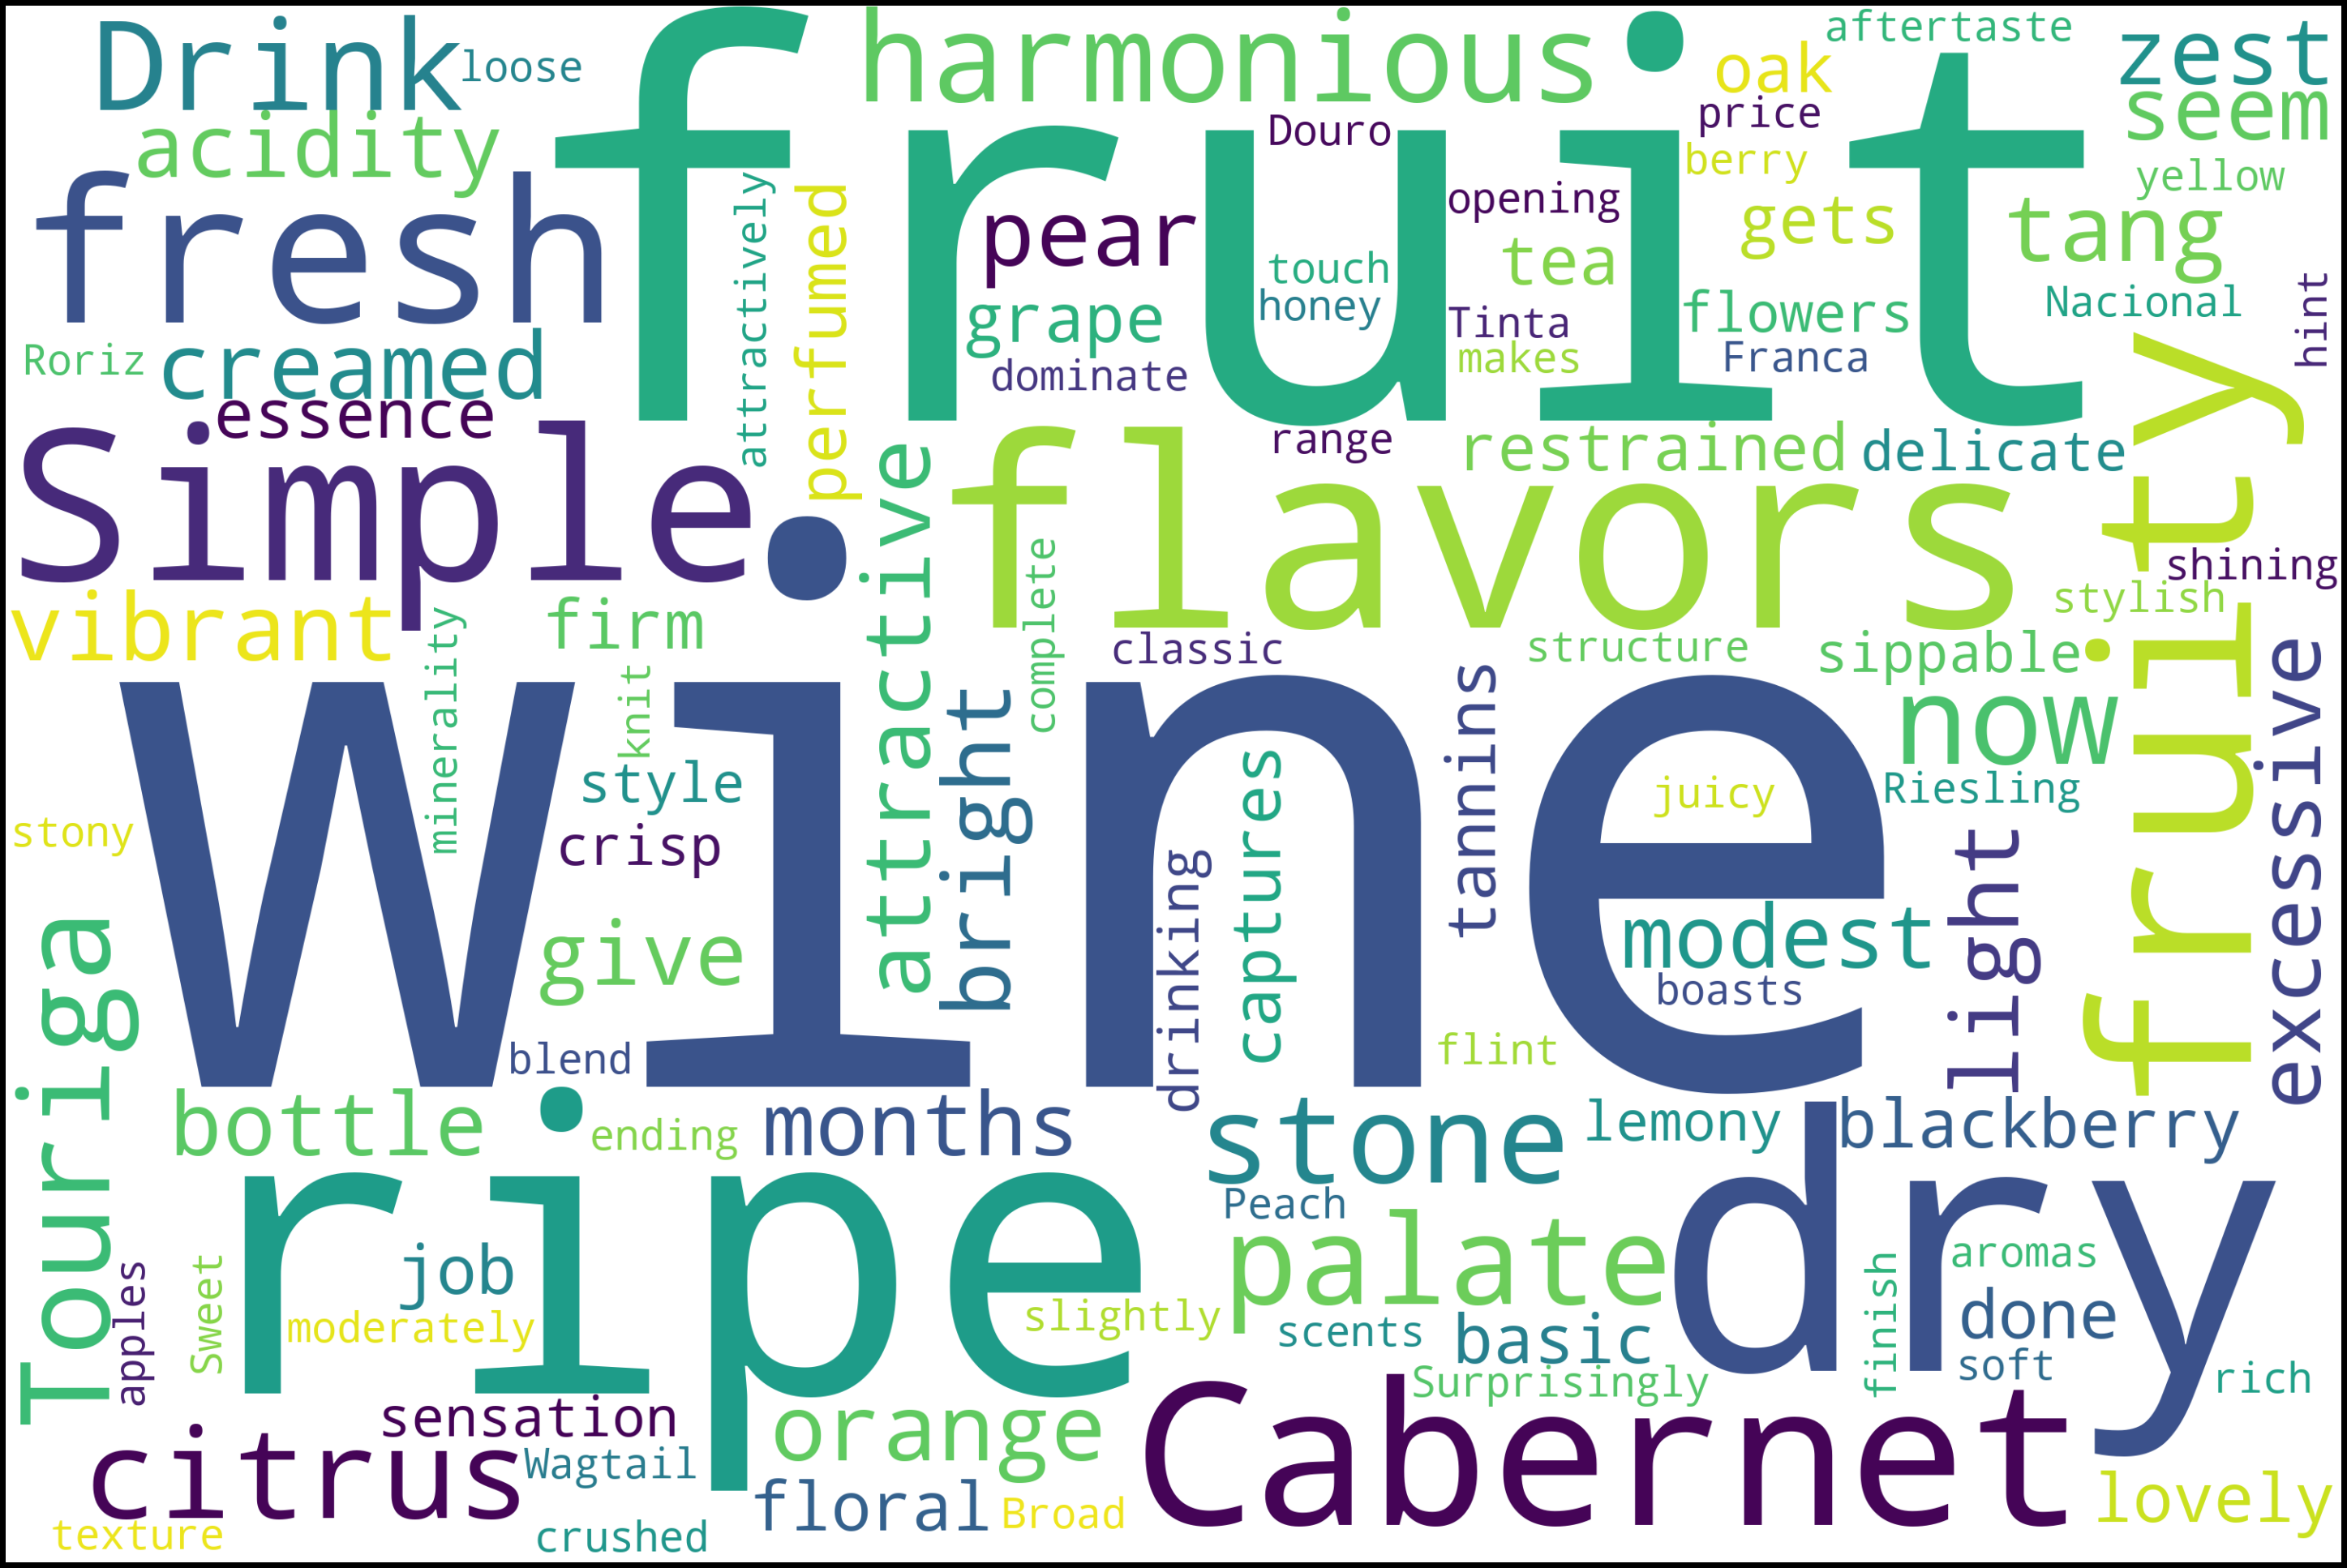

In [ ]:
#looking at the wordcloud 

text = df_train_valid.description.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

adding "wine" to stopword list:

In [ ]:
my_stop_words = STOPWORDS.add("wine")

Looking for NaN values:

In [ ]:
df_train_valid.isna().sum()

country            5
description        0
designation    36518
province           5
region_1       20008
region_2       72008
variety            0
winery             0
quality            0
dtype: int64

Filling NaN values for country and province:

In [ ]:
df_train_valid["country"]=df_train_valid["country"].fillna("Missing")
df_train_valid["province"]=df_train_valid["province"].fillna("NotSpecified")

Testing Rige and LinearRegression on the variation of max_features, including or not province and country. (more values for n_features have been tested):

In [ ]:
n_features = [100000, None]
localization = ["country", "province", "both", None]
regressors = {'lr': LinearRegression(), 'ridge':Ridge()}

In [ ]:
import csv
with open('./drive/MyDrive/Competition/LinearVsRige.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow([ "Model", "n_features", "granularity", "mae", "mse", "r2"])
  for n in n_features:
    for granularity in localization:
      description_train_valid = df_train_valid["description"]
      description_test = df_test["description"]
      variety_train_valid =  df_train_valid[["variety"]]
      variety_test = df_test[["variety"]]
      winery_train_valid =  df_train_valid[["winery"]]
      winery_test = df_test[["winery"]]
      y_train_valid=df_train_valid["quality"]

      if granularity == "country":
        country_train_valid = df_train_valid[["country"]]
        country_test = df_test[["country"]]
        encCou = OneHotEncoder(sparse=True,handle_unknown="ignore")
        cou_1h_train_valid = encCou.fit_transform(country_train_valid)
        cou_1h_test = encCou.transform(country_test)
      if granularity == "province":
        province_train_valid = df_train_valid[["province"]]
        province_test = df_test[["province"]]
        encPro = OneHotEncoder(sparse=True,handle_unknown="ignore")
        pro_1h_train_valid = encPro.fit_transform(province_train_valid)
        pro_1h_test = encPro.transform(province_test) 
      if granularity == "both":
        encCou = OneHotEncoder(sparse=True,handle_unknown="ignore")
        encPro = OneHotEncoder(sparse=True,handle_unknown="ignore")
        country_train_valid = df_train_valid[["country"]]
        country_test = df_test[["country"]]
        province_train_valid = df_train_valid[["province"]]
        province_test = df_test[["province"]] 
        cou_1h_train_valid = encCou.fit_transform(country_train_valid)
        cou_1h_test = encCou.transform(country_test)
        pro_1h_train_valid = encPro.fit_transform(province_train_valid)
        pro_1h_test = encPro.transform(province_test) 

      encVar = OneHotEncoder(sparse=True,handle_unknown="ignore")
      encWin = OneHotEncoder(sparse=True,handle_unknown="ignore")
      var_1h_train_valid = encVar.fit_transform(variety_train_valid)
      var_1h_test = encVar.transform(variety_test)
      win_1h_train_valid = encWin.fit_transform(winery_train_valid)
      win_1h_test = encWin.transform(winery_test)
      vectorizer = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1,2))
      desc_tfidf_train_valid = vectorizer.fit_transform(description_train_valid)
      desc_tfidf_test = vectorizer.transform(description_test)  

      if granularity == "both":
        stck1_train_valid = sparse.hstack( (cou_1h_train_valid,pro_1h_train_valid) )   
        stck2_train_valid = sparse.hstack( (stck1_train_valid, var_1h_train_valid) )
        stck3_train_valid = sparse.hstack( (stck2_train_valid, win_1h_train_valid) )
        X_train_valid = sparse.hstack( (stck3_train_valid, desc_tfidf_train_valid) )

        stck1_test = sparse.hstack( (cou_1h_test,pro_1h_test) )   
        stck2_test = sparse.hstack( (stck1_test, var_1h_test) )
        stck3_test = sparse.hstack( (stck2_test, win_1h_test) )
        X_test = sparse.hstack( (stck3_test, desc_tfidf_test) )
      if granularity == "province":  
        stck2_train_valid = sparse.hstack( (pro_1h_train_valid, var_1h_train_valid) )
        stck3_train_valid = sparse.hstack( (stck2_train_valid, win_1h_train_valid) )
        X_train_valid = sparse.hstack( (stck3_train_valid, desc_tfidf_train_valid) )

        stck2_test = sparse.hstack( (pro_1h_test, var_1h_test) )
        stck3_test = sparse.hstack( (stck2_test, win_1h_test) )
        X_test = sparse.hstack( (stck3_test, desc_tfidf_test) )
      if granularity == "country":  
        stck2_train_valid = sparse.hstack( (cou_1h_train_valid, var_1h_train_valid) )
        stck3_train_valid = sparse.hstack( (stck2_train_valid, win_1h_train_valid) )
        X_train_valid = sparse.hstack( (stck3_train_valid, desc_tfidf_train_valid) )

        stck2_test = sparse.hstack( (cou_1h_test, var_1h_test) )
        stck3_test = sparse.hstack( (stck2_test, win_1h_test) )
        X_test = sparse.hstack( (stck3_test, desc_tfidf_test) )
      if granularity == None:
        stck3_train_valid = sparse.hstack( (var_1h_train_valid, win_1h_train_valid) )
        X_train_valid = sparse.hstack( (stck3_train_valid, desc_tfidf_train_valid) )

        stck3_test = sparse.hstack( (var_1h_test, win_1h_test) )
        X_test = sparse.hstack( (stck3_test, desc_tfidf_test) )

      
      for name in regressors:
        model = regressors[name]
        mae, mse, r2 = evaluate_model(X_train_valid, y_train_valid, model)
        writer.writerow([ name, n, granularity, mae, mse, r2])


Just re-run with the best choice, performing now grid search on hyperparameters:


In [ ]:
vectorizer = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1,2), max_features=380000)
desc_tfidf_train_valid = vectorizer.fit_transform(description_train_valid)

In [ ]:
description_train_valid = df_train_valid["description"]
description_test = df_test["description"]
variety_train_valid =  df_train_valid[["variety"]]
variety_test = df_test[["variety"]]
winery_train_valid =  df_train_valid[["winery"]]
winery_test = df_test[["winery"]]
y_train_valid=df_train_valid["quality"]
country_train_valid = df_train_valid[["country"]]
country_test = df_test[["country"]]
province_train_valid = df_train_valid[["province"]]
province_test = df_test[["province"]] 

encVar = OneHotEncoder(sparse=True,handle_unknown="ignore")
encWin = OneHotEncoder(sparse=True,handle_unknown="ignore")
encCou = OneHotEncoder(sparse=True,handle_unknown="ignore")
encPro = OneHotEncoder(sparse=True,handle_unknown="ignore")

cou_1h_train_valid = encCou.fit_transform(country_train_valid)
cou_1h_test = encCou.transform(country_test)
pro_1h_train_valid = encPro.fit_transform(province_train_valid)
pro_1h_test = encPro.transform(province_test) 



encVar = OneHotEncoder(sparse=True,handle_unknown="ignore")
encWin = OneHotEncoder(sparse=True,handle_unknown="ignore")
var_1h_train_valid = encVar.fit_transform(variety_train_valid)
var_1h_test = encVar.transform(variety_test)
win_1h_train_valid = encWin.fit_transform(winery_train_valid)
win_1h_test = encWin.transform(winery_test)


vectorizer = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1,2), max_features=380000)
desc_tfidf_train_valid = vectorizer.fit_transform(description_train_valid)
desc_tfidf_test = vectorizer.transform(description_test)

stck1_train_valid = sparse.hstack( (cou_1h_train_valid,pro_1h_train_valid) )   
stck2_train_valid = sparse.hstack( (stck1_train_valid, var_1h_train_valid) )
stck3_train_valid = sparse.hstack( (stck2_train_valid, win_1h_train_valid) )
X_train_valid = sparse.hstack( (stck3_train_valid, desc_tfidf_train_valid) )

stck1_test = sparse.hstack( (cou_1h_test,pro_1h_test) )   
stck2_test = sparse.hstack( (stck1_test, var_1h_test) )
stck3_test = sparse.hstack( (stck2_test, win_1h_test) )
X_test = sparse.hstack( (stck3_test, desc_tfidf_test) )

param_grid = {
  "fit_intercept": [True, False],
  "normalize": [True, False],
  "tol": [0.0001, 0.001, 0.01],
  "alpha": [1,5,10,100]
  }
gs = GridSearchCV(Ridge(), param_grid, scoring="r2", cv=3)
gs.fit(X_train_valid, y_train_valid)


#mae, mse, r2 = evaluate_model(X_train_valid, y_train_valid, model)

result of the gridSearch:

In [ ]:
gs.best_score_

0.7616129705567923

In [ ]:
gs.cv_results_

{'mean_fit_time': array([ 2.83618879, 31.10818617, 27.93870258, 27.82002918,  2.39776413,
        23.41984979, 21.30216217, 21.28454177,  2.08920892, 20.27539635,
        17.90575194, 17.56071782,  1.83252819, 17.3215429 , 16.07350771,
        16.03912719,  1.81753135, 16.12670493, 14.2254955 , 14.30905692]),
 'mean_score_time': array([0.02198609, 0.02186211, 0.02195175, 0.02630647, 0.02139695,
        0.0214227 , 0.02358246, 0.02142326, 0.02174203, 0.02180926,
        0.0251596 , 0.02198815, 0.02189755, 0.02266892, 0.02717026,
        0.02202447, 0.02356871, 0.02080838, 0.02559272, 0.02141174]),
 'mean_test_score': array([0.69309259, 0.76161297, 0.76067724, 0.76067724, 0.67772821,
        0.74394872, 0.74263171, 0.74263171, 0.65977607, 0.72975869,
        0.72800992, 0.72800992, 0.64153289, 0.71801801, 0.71581103,
        0.71581103, 0.62371384, 0.70795481, 0.70527874, 0.70527874]),
 'param_alpha': masked_array(data=[1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
              

predict on eval dataset and write the output:

In [ ]:
y_pred = gs.predict(X_test)
import csv
with open('./drive/MyDrive/Competition/ridge-both-final-gs-last.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow([ "Id","Predicted"])
  for i, el in enumerate(y_pred):
    writer.writerow([ i, el])

gs-best score: 0.7616129705567923
